relu:0.9033

elu:0.9032 はじめの損失がreluより小さい

logsigmoid:0.8371 あまり向いてない。損失の降下が遅い

softmax:0.1135 全然できない

sigmoid:0.1953 全然できない

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [2]:
#各要素は画像データに対応するtorch.tensorとラベルからなる。
'''
root[str]: データの保存（または参照）場所
train[bool]: Trueなら訓練データセット、Falseならテストデータセットを取得
download[bool]: データがrootで指定したパスに存在しない場合、ダウンロードするかどうかを指定
'''
train_dataset = torchvision.datasets.MNIST(
    root ='./data',
    train=True,
    transform=transforms.ToTensor(),
    download=True,
)

test_dataset = torchvision.datasets.MNIST(
    root ='./data',
    train=False,
    transform=transforms.ToTensor(),
    download=True,
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 477kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.85MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.75MB/s]


In [6]:
batch_size = 256

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)


In [67]:
class Net(nn.Module):
    def __init__(self, input_size, hidden1_size, hidden2_size, output_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.fc3 = nn.Linear(hidden2_size, output_size)

    def forward(self, x): # x : 入力
        z1 = F.relu(self.fc1(x))
        z2 = F.relu(self.fc2(z1))
        y = self.fc3(z2)
        return y


In [19]:
class Net(nn.Module):
    def __init__(self, input_size, hidden1_size, hidden2_size, output_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.fc3 = nn.Linear(hidden2_size, output_size)

    def forward(self, x): # x : 入力
        z1 = F.elu(self.fc1(x))
        z2 = F.elu(self.fc2(z1))
        y = self.fc3(z2)
        return y

In [31]:
class Net(nn.Module):
    def __init__(self, input_size, hidden1_size, hidden2_size, output_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.fc3 = nn.Linear(hidden2_size, output_size)

    def forward(self, x): # x : 入力
        z1 = F.logsigmoid(self.fc1(x))
        z2 = F.logsigmoid(self.fc2(z1))
        y = self.fc3(z2)
        return y

In [43]:
class Net(nn.Module):
    def __init__(self, input_size, hidden1_size, hidden2_size, output_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.fc3 = nn.Linear(hidden2_size, output_size)

    def forward(self, x): # x : 入力
        z1 = F.softmax(self.fc1(x))
        z2 = F.softmax(self.fc2(z1))
        y = self.fc3(z2)
        return y

In [55]:
class Net(nn.Module):
    def __init__(self, input_size, hidden1_size, hidden2_size, output_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.fc3 = nn.Linear(hidden2_size, output_size)

    def forward(self, x): # x : 入力
        z1 = F.sigmoid(self.fc1(x))
        z2 = F.sigmoid(self.fc2(z1))
        y = self.fc3(z2)
        return y

In [68]:
input_size = 28*28
hidden1_size = 1024
hidden2_size = 512
output_size = 10

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Net(input_size, hidden1_size, hidden2_size, output_size).to(device)
print(model)


Net(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
)


In [69]:
# 損失関数　criterion：基準
# CrossEntropyLoss：交差エントロピー誤差関数
criterion = nn.CrossEntropyLoss()

# 最適化法の指定　optimizer：最適化
# SGD：確率的勾配降下法
optimizer = optim.SGD(model.parameters(), lr=0.01)


In [70]:
def train_model(model, train_loader, criterion, optimizer, device='cpu'):

    train_loss = 0.0
    num_train = 0

    # 学習モデルに変換
    model.train()

    for i, (images, labels) in enumerate(train_loader):
        # batch数をカウント
        num_train += len(labels)

        images, labels = images.view(-1, 28*28).to(device), labels.to(device)

        # 勾配を初期化
        optimizer.zero_grad()

        # 推論(順伝播)
        outputs = model(images)

        # 損失の算出
        loss = criterion(outputs, labels)

        # 誤差逆伝播
        loss.backward()

        # パラメータの更新
        optimizer.step()

        # lossを加算
        train_loss += loss.item()

    # lossの平均値を取る
    train_loss = train_loss / num_train

    return train_loss


In [71]:
def test_model(model, test_loader, criterion, optimizer, device='cpu'):

    test_loss = 0.0
    num_test = 0

    # modelを評価モードに変更
    model.eval()

    with torch.no_grad(): # 勾配計算の無効化
        for i, (images, labels) in enumerate(test_loader):
            num_test += len(labels)
            images, labels = images.view(-1, 28*28).to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

        # lossの平均値を取る
        test_loss = test_loss / num_test
    return test_loss


In [72]:
def learning(model, train_loader, test_loader, criterion, opimizer, num_epochs, device='cpu'):

    train_loss_list = []
    test_loss_list = []

    # epoch数分繰り返す
    for epoch in range(1, num_epochs+1, 1):

        train_loss = train_model(model, train_loader, criterion, optimizer, device=device)
        test_loss = test_model(model, test_loader, criterion, optimizer, device=device)

        print("epoch : {}, train_loss : {:.5f}, test_loss : {:.5f}" .format(epoch, train_loss, test_loss))

        train_loss_list.append(train_loss)
        test_loss_list.append(test_loss)

    return train_loss_list, test_loss_list


In [73]:
num_epochs = 10
train_loss_list, test_loss_list = learning(model, train_loader, test_loader, criterion, optimizer, num_epochs, device=device)


epoch : 1, train_loss : 0.00869, test_loss : 0.00839
epoch : 2, train_loss : 0.00717, test_loss : 0.00584
epoch : 3, train_loss : 0.00445, test_loss : 0.00348
epoch : 4, train_loss : 0.00291, test_loss : 0.00250
epoch : 5, train_loss : 0.00226, test_loss : 0.00204
epoch : 6, train_loss : 0.00193, test_loss : 0.00180
epoch : 7, train_loss : 0.00173, test_loss : 0.00162
epoch : 8, train_loss : 0.00160, test_loss : 0.00150
epoch : 9, train_loss : 0.00151, test_loss : 0.00142
epoch : 10, train_loss : 0.00144, test_loss : 0.00136


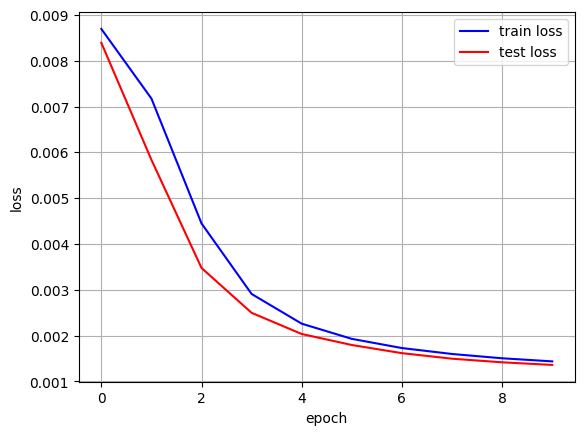

In [74]:
plt.plot(range(len(train_loss_list)), train_loss_list, c='b', label='train loss')
plt.plot(range(len(test_loss_list)), test_loss_list, c='r', label='test loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.grid()
plt.show()


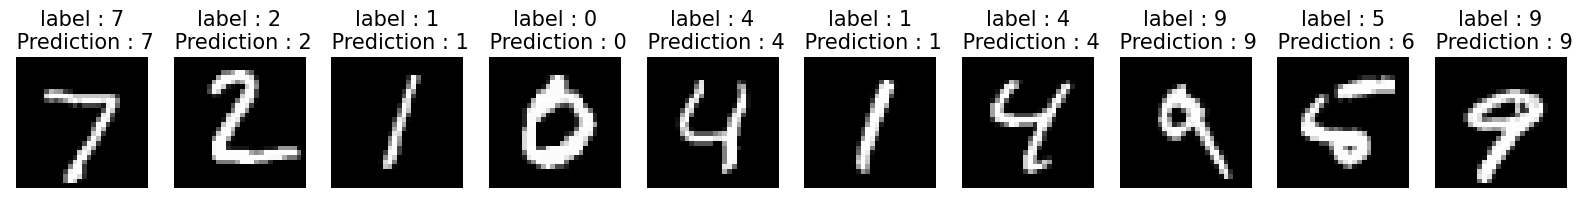

In [75]:
plt.figure(figsize=(20, 10))
for i in range(10):
    image, label = test_dataset[i]
    image = image.view(-1, 28*28).to(device)

    # 推論
    prediction_label = torch.argmax(model(image))

    ax = plt.subplot(1, 10, i+1)

    plt.imshow(image.detach().to('cpu').numpy().reshape(28, 28), cmap='gray')
    ax.axis('off')
    ax.set_title('label : {}\n Prediction : {}'.format(label, prediction_label), fontsize=15)
plt.show()


In [76]:
correct_estimate = 0
incorrect_index_list =[]
prediction_label_of_incorrect_index = []

for i in range(len(test_dataset)):
  image, label = test_dataset[i]
  image = image.view(-1, 28*28).to(device)

  prediction_label = torch.argmax(model(image))

  if prediction_label == label:
    correct_estimate += 1
  elif len(incorrect_index_list) < 10:
    incorrect_index_list.append(i)
    prediction_label_of_incorrect_index.append(prediction_label)


print(f'正解数:{correct_estimate}　テストデータ総数:{len(test_dataset)}　正解率:{correct_estimate/len(test_dataset)}')
#訓練しなおすとほんの少しだけ正解数が変動するはず

正解数:9013　テストデータ総数:10000　正解率:0.9013


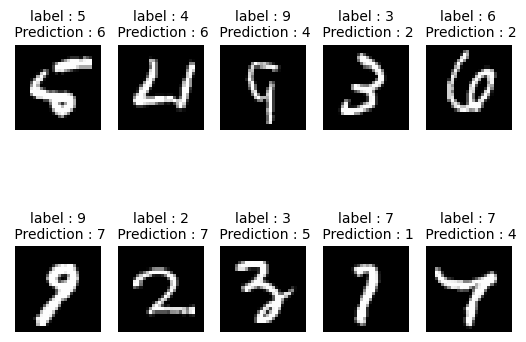

In [77]:
#誤った予測を立ててしまった画像のうちの10個に対し、予測と正解、画像を表示する。
for i in range(len(incorrect_index_list)):
  image, label = test_dataset[incorrect_index_list[i]]
  ax = plt.subplot(2, 5, i+1)
  plt.imshow(image.detach().to('cpu').numpy().reshape(28, 28), cmap='gray')
  ax.axis('off')
  ax.set_title('label : {}\n Prediction : {}'.format(label, prediction_label_of_incorrect_index[i]), fontsize=10)
plt.show()

# 5.5 GoogleColabのGPU設定
機械学習では大規模なデータセットを用いて学習するため、往々にして大量の計算が必要になる。このような場合、CPUだけに演算させているのでは学習に時間がかかりすぎる。そのため、並列演算が得意な**GPU**を使いたい。GoogleColabには、無料のGPU環境が整備されている。

1. 「編集」タブを開く
2. 「ノートブックの設定」をクリック
3. 「ハードウェアアクセラレータ」から、T4GPUを選択。
4. 保存する

これで、GPUを使うことができる。

次のコードを実行してみよう。GPU設定済ならTrue, そうでなければFalseが返される。

In [78]:
print(torch.cuda.is_available())

True


# 5.6 演習問題
##[注意]課題1と課題2ではノートブックを分けてください
### 課題1[必須課題]
上の例では、MNISTデータセットを用いて予測器を訓練した。用いるデータセットをFashionMNISTデータセットに変更して訓練せよ。(サンプルコードを動かすだけでよい)

### 課題2[任意課題]
サンプルコードでは、活性化関数にReLUを使っている。これを別の活性化関数に変更することで結果がどう変わったか（またはさほど変わらなかったか）説明せよ。

参考:https://qiita.com/sudominoru/items/1c6dbf390da9a90f2c17

### 課題3[任意課題]
なぜ多種類の活性化関数が存在するのか。以下の記事を読んでみよう！

https://ai-scholar.tech/articles/survey/activation-functions-review


以下、FashionMNISTの説明

FashionMNISTデータセットには、MNISTと同様に画像データが格納されている。違いとしては、画像として保存されているものが


*   MNIST : 0～9の手書き数字
*   FashionMNIST : 10種類の衣類

である。

